In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *

In [2]:
params = np.load('data/Human_9.npz')
hi = params['hi']
Jij = params['Jij']

In [3]:
datasets = ['train', 'test', 'model']
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] =  np.loadtxt('data/%s_matrix.csv.gz' % dataset).astype(int)

In [4]:
observables = ['fi', 'fij', 'cij', 'fijk', 'cijk', 'fold_ijk']#, 'fijkl']
observables_dict = {key: dict() for key in observables}
for dataset in ['train', 'test', 'model']:
    params = np.load('data/%s_observables.npz'%dataset)
    for observable in observables:
        observables_dict[observable][dataset] = params[observable]

In [5]:
fi = observables_dict['fi']['train'].mean(axis=0)
sample_independent = np.random.choice(np.arange(0, 20, 1), size=sample_matrices['test'].shape, p=fi)

In [6]:
arr = np.load('../aafreqpca/data/data.npz')
aa_human = arr['human']

In [7]:
cov = np.cov(aa_human.T)
alpha = np.mean(aa_human, axis=0)
alpha0 = alpha*(1-alpha)/np.diag(cov) - 1.0
alpha0

array([103.97144572,  52.27539978, 173.05226162,  84.67300122,
       140.7069723 ,  92.61090593, 172.27398996, 116.7177847 ,
        78.21749722, 112.76767947, 235.91539032, 169.00405327,
        67.41864509, 145.6206498 , 118.92310653, 114.44634793,
       191.08027332, 178.04419657, 198.44854756, 169.26510308])

(array([  16.,  107.,  521., 1521., 2914., 3777., 3639., 3001., 1962.,
        1148.,  665.,  320.,  186.,   85.,   63.,   52.,   19.,   14.,
          21.,   10.,    5.,    7.,    5.,    6.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24]),
 <a list of 1 Patch objects>)

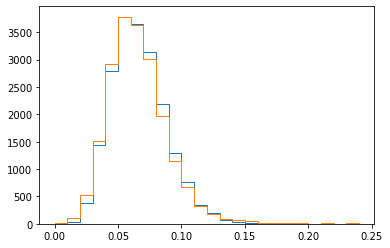

In [8]:
p = np.random.dirichlet(alpha*np.mean(alpha0), size=aa_human.shape[0])
bins = np.arange(0, 0.25, 0.01)
plt.hist(p[:, 5], bins=bins, histtype='step')
plt.hist(aa_human[:, 5], bins=bins, histtype='step')

In [9]:
sampless = []
ps = np.random.dirichlet(alpha*np.mean(alpha0), size=aa_human.shape[0]//2)
blocklength = sample_matrices['test'].shape[0]//len(ps)
for p in ps:
    samples = np.random.choice(np.arange(0, 20, 1),
                               size=(blocklength, sample_matrices['test'].shape[1]),
                               p=p)
    sampless.append(samples)
sample_dirichlet = np.concatenate(sampless)

In [10]:
sampless = []
ps = aa_human
blocklength = sample_matrices['test'].shape[0]//len(ps)
for p in ps:
    samples = np.random.choice(np.arange(0, 20, 1),
                               size=(blocklength, sample_matrices['test'].shape[1]),
                               p=p)
    sampless.append(samples)
sample_composition = np.concatenate(sampless)

In [11]:
energies = {}
for dataset in ['test', 'model']:
    energies[dataset] = np.array([energy_potts(x, hi, Jij) for x in sample_matrices[dataset]])
energies['independent'] = np.array([energy_potts(x, hi, Jij) for x in sample_independent])
energies['dirichlet'] = np.array([energy_potts(x, hi, Jij) for x in sample_dirichlet])

In [12]:
energies['composition'] = np.array([energy_potts(x, hi, Jij) for x in sample_composition])

In [13]:
sample_cov =  np.loadtxt('../globalmaxent/data/model_matrix.csv.gz').astype(int)
energies['cov'] = np.array([energy_potts(x, hi, Jij) for x in sample_cov])

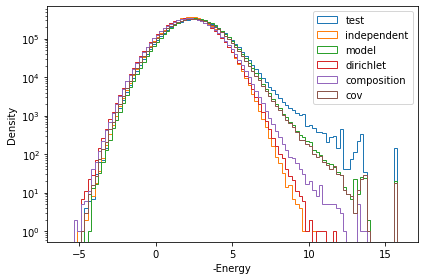

In [14]:
bins = np.linspace(-6, 16, 100)
fig, ax = plt.subplots()
for dataset in ['test', 'independent', 'model', 'dirichlet', 'composition', 'cov']:
    ax.hist(-energies[dataset], bins=bins, histtype='step', label=dataset)
#ax.hist(-energies_independent, bins=bins, histtype='step', label='independent')
#ax.hist(-energies_model, bins=bins, histtype='step', label='maxent')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('-Energy')
ax.set_ylabel('Density')
fig.tight_layout()
fig.savefig('density_of_states.png')

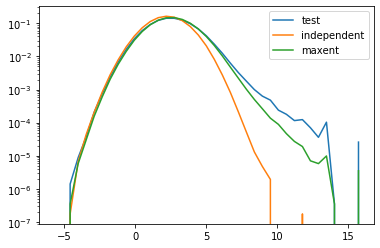

In [11]:
plot_histograms((-energies_test, -energies_independent, -energies_model),
                ('test', 'independent', 'maxent'),
                xmin=-6, xmax=16)
plt.yscale('log')